In [189]:
import pandas as pd
from pandas import DataFrame

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from matplotlib.patches import Circle
from matplotlib.text import Text
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.lines import Line2D

from typing import Tuple

In [170]:
events = pd.read_csv('events.csv', index_col=0)
rallies = pd.read_csv('rallies.csv', index_col=0)
points = pd.read_csv('points.csv', index_col=0)
serves = pd.read_csv('serves.csv', index_col=0)

In [171]:
# fill nans
events.loc[events['receiver'].isna() & (events['hitter'] == 'Nadal'), 'receiver'] = 'Djokovic'
events.loc[events['receiver'].isna() & (events['hitter'] == 'Djokovic'), 'receiver'] = 'Nadal'

rallies.loc[rallies['returner'].isna() & (rallies['server'] == 'Nadal'), 'returner'] = 'Djokovic'
rallies.loc[rallies['returner'].isna() & (rallies['server'] == 'Djokovic'), 'returner'] = 'Nadal'

points.loc[points['returner'].isna() & (points['server'] == 'Nadal'), 'returner'] = 'Djokovic'
points.loc[points['returner'].isna() & (points['server'] == 'Djokovic'), 'returner'] = 'Nadal'

In [172]:
# court dimensions in meters
court_width = 10.97
court_length = 23.77

baseline_clearance = 6.4
sideline_clearance = 3.66
net_margin = .91

doubles_alley = 1.37
service_box_length = 6.4
center_mark_length = 0.1

In [173]:
def draw_court(hide_axes: bool = False) -> Tuple[Figure, Axes]:
    """
    Sets up tennis court for plotting.

    Parameters
    ----------
    hide_axes : bool
        If True, hides the axes.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object.
    axes : matplotlib.axes.Axes
        The axes object.
    """

    # initialize figure
    fig = plt.figure(figsize=(court_width/2, court_length/2))
    fig.patch.set_facecolor('#5080B0')

    axes = fig.add_subplot(1, 1, 1, facecolor='#5080B0')

    if hide_axes:
        axes.xaxis.set_visible(False)
        axes.yaxis.set_visible(False)
        axes.axis('off')
    
    # draw court lines
    axes = draw_lines(axes)

    axes.set_aspect('equal')
    
    return fig, axes

def draw_lines(axes: Axes) -> Axes:
    """
    Draws the lines on the tennis court.

    Parameters
    ----------
    axes : matplotlib.axes.Axes
        The axes object to draw the lines on.
        
    Returns
    -------
    axes : matplotlib.axes.Axes
        The axes object with the lines drawn.
    """
    # set limits, so that the court is centered and clearance is accounted for
    axes.set_xlim(-court_width/2 - sideline_clearance, court_width/2 + sideline_clearance)
    axes.set_ylim(-court_length/2 - baseline_clearance, court_length/2 + baseline_clearance)
    
    # court outline
    x = -court_width/2
    dx = court_width
    y = -court_length/2
    dy = court_length
    axes.add_patch(plt.Rectangle((x, y), 
                                 dx, dy,
                                 edgecolor="white", 
                                 facecolor="#5581A6", 
                                 alpha=1))
    
    # net
    axes.add_line(plt.Line2D([-court_width/2 - net_margin, court_width/2 + net_margin],
                             [0, 0],
                             c='w'))
    
    # sidelines
    x = -court_width/2 + doubles_alley
    dx = court_width - 2*doubles_alley
    y = -court_length/2
    dy = court_length
    axes.add_patch(plt.Rectangle((x,y), dx, dy,
                                  edgecolor="white", facecolor="#5581A6", alpha=1))
    
    # service boxes
    x = -court_width/2 + doubles_alley
    dx = court_width - doubles_alley*2
    y = -service_box_length
    dy = service_box_length*2
    axes.add_patch(plt.Rectangle((x, y), dx, dy,
                       edgecolor="white", facecolor="none", alpha=1))
    
    # centerline
    axes.add_line(plt.Line2D([0, 0],
                             [-service_box_length, service_box_length],
                             c='w'))
    
    # center mark
    axes.add_line(plt.Line2D([0, 0],
                             [-court_length/2, -court_length/2 + center_mark_length],
                             c='w'))
    axes.add_line(plt.Line2D([0, 0],
                             [court_length/2, court_length/2 - center_mark_length],
                             c='w'))

    return axes

In [174]:
def draw_static_players(axes: Axes,
                 hitter_x: float, hitter_y: float, hitter_name: str,
                 receiver_x: float, receiver_y: float, receiver_name: str) -> Axes:
    
    """Draws players on the court.
    
    Parameters
    ----------
    axes : matplotlib.axes.Axes
        The axes object to draw the players on.
    hitter_x : float
        The x-coordinate of the hitter.
    hitter_y : float
        The y-coordinate of the hitter.
    hitter_name : str
        The name of the hitter.
    receiver_x : float
        The x-coordinate of the receiver.
    receiver_y : float
        The y-coordinate of the receiver.
    receiver_name : str
        The name of the receiver.

    Returns
    -------
    axes : matplotlib.axes.Axes
        The axes with the players drawn.
    """   

    # player circle marker radius
    radius = 0.5

    # player abbreviations
    player_abbrev = {'Djokovic' : 'D', 'Nadal' : 'N'}

    # player colors
    player_colors = {'Djokovic' : 'blue', 'Nadal' : 'orange'}

    # draw hitter
    axes.add_artist(Circle((hitter_x, hitter_y),
                            radius=radius,
                            edgecolor=player_colors[hitter_name], 
                            linewidth=2, facecolor='white',
                            alpha=1, zorder=20))
    
    axes.text(hitter_x, hitter_y, 
              player_abbrev[hitter_name], 
              horizontalalignment='center', verticalalignment='center',
              fontsize=10, color='black', zorder=30)
                
    # draw receiver
    axes.add_artist(Circle((receiver_x, receiver_y),
                            radius=radius,
                            edgecolor=player_colors[receiver_name], 
                            linewidth=2, facecolor='white',
                            alpha=1, zorder=20))
    
    axes.text(receiver_x, receiver_y, 
              player_abbrev[receiver_name],
              horizontalalignment='center', verticalalignment='center',
              fontsize=10, color='black', zorder=30)
    
    return axes

In [175]:
def draw_static_ball(axes : Axes, b_x : float, b_y : float) -> Axes:
    """Draws the ball on the court.
    
    Parameters
    ----------
    axes : matplotlib.axes.Axes
        The axes to draw on.
    b_x : float
        The x-coordinate of the ball.
    b_y : float
        The y-coordinate of the ball.

    Returns
    -------
    axes : matplotlib.axes.Axes
        The axes with the ball drawn.
    """

    # tennis ball radius
    radius = .2

    # ellipse color
    color = '#CCE200'

    # draw ball 
    axes.add_artist(Circle((b_x,b_y),
                           radius=radius, facecolor=color,
                           alpha=1, zorder=20))
    return axes

In [176]:
# transform coordinates so origin is at the center of the court
events['hitter_x'] = events['hitter_x'] - court_width/2
events['hitter_y'] = events['hitter_y'] - court_length/2
events['receiver_x'] = events['receiver_x'] - court_width/2
events['receiver_y'] = events['receiver_y'] - court_length/2

rallies['x'] = rallies['x'] - court_width/2
rallies['y'] = rallies['y'] - court_length/2

points['x'] = points['x'] - court_width/2
points['y'] = points['y'] - court_length/2

serves['x'] = serves['x'] - court_width/2
serves['y'] = serves['y'] - court_length/2

In [177]:
# recalculate rally durations since dataset is not accurate
rally_durations = (events.groupby('rallyid')['time']
                   .agg(lambda x: x.max() - x.min())
                   .reset_index()
                   .rename(columns={'time': 'totaltime'}))

# update rally durations
rallies = rallies.drop(columns=['totaltime'])
points = points.drop(columns=['totaltime'])
rallies = pd.merge(rallies, rally_durations, on='rallyid', how='left')
points = pd.merge(points, rally_durations, on='rallyid', how='left')

# Move 'totaltime' right after 'rallyid'
cols = rallies.columns.tolist()
cols.insert(cols.index('strokes') + 1, cols.pop(cols.index('totaltime')))
rallies = rallies[cols]

cols = points.columns.tolist()
cols.insert(cols.index('strokes') + 1, cols.pop(cols.index('totaltime')))
points = points[cols]

In [178]:
# retrieve final position of ball
final_pos = rallies[['rallyid', 'x', 'y']].copy()
final_pos = final_pos.rename(columns={'x': 'hitter_x', 'y': 'hitter_y'})
final_pos['frameid'] = 300000 # set frameid to faux frame
final_pos['strokeid'] = 50 # set strokeid to faux stroke

In [179]:
# set up table to calculate player movement
delta_players = (events
                 .groupby('rallyid')[['hitter_x','hitter_y','receiver_x','receiver_y']]
                 .shift(-1)
                 .rename(columns={'hitter_x' : 'hitter_x_2',
                          'hitter_y' : 'hitter_y_2',
                          'receiver_x' : 'receiver_x_2', 
                          'receiver_y' : 'receiver_y_2'}
                        )
                )

shots = pd.concat([events, delta_players], axis=1)

In [180]:
# calculate dx and dy of player movement
shots['h_dx'] = shots['receiver_x_2'] - shots['hitter_x']
shots['h_dy'] = shots['receiver_y_2'] - shots['hitter_y']
shots['r_dx'] = shots['hitter_x_2'] - shots['receiver_x']
shots['r_dy'] = shots['hitter_y_2'] - shots['receiver_y']

# assume player still at end of point
shots['h_dx'] = shots['h_dx'].fillna(0)
shots['h_dy'] = shots['h_dy'].fillna(0)
shots['r_dx'] = shots['r_dx'].fillna(0)
shots['r_dy'] = shots['r_dy'].fillna(0)

shots.drop(columns=['hitter_x_2', 'hitter_y_2', 'receiver_x_2', 'receiver_y_2'], inplace=True)

In [181]:
# concatenate events and final_pos
shots = pd.concat([shots, final_pos], ignore_index=True)
shots = shots.sort_values(by=['rallyid','frameid'])

# find dx, dy of ball and dt
delta_ball = shots.groupby('rallyid')[['hitter_x', 'hitter_y', 'time']].diff(1).shift(-1)
delta_ball = delta_ball.rename(columns={'hitter_x': 'b_dx', 'hitter_y': 'b_dy', 'time': 'dt',})

shots = pd.merge(shots, delta_ball, left_index=True, right_index=True) # merge ball displacement with original df

shots['dt'] = shots['dt'].fillna(.5) # assume last shot took half a second

# hitter velocity
shots['h_vx'] = shots['h_dx'] / shots['dt']
shots['h_vy'] = shots['h_dy'] / shots['dt']

# receiver velocity
shots['r_vx'] = shots['r_dx'] / shots['dt']
shots['r_vy'] = shots['r_dy'] / shots['dt']

# ball velocity
shots['b_vx'] = shots['b_dx'] / shots['dt']
shots['b_vy'] = shots['b_dy'] / shots['dt']

# clean up dataframe
shots = shots.sort_index()
shots = shots[shots['frameid'] != 300000]

In [186]:
def draw_ball(b_x: float, b_y: float,) -> Circle:
    """Draws the ball on the court.
    
    Parameters
    ----------
    b_x : float
        The x-coordinate of the ball.
    b_y : float
        The y-coordinate of the ball.

    Returns
    -------
    Circle : matplotlib.patches.Circle
        Ball object itself.
    """

    # tennis ball radius
    radius = .2

    # ellipse color
    color = '#CCE200'

    # draw ball 
    return Circle((b_x,b_y),
                  radius=radius, facecolor=color,
                  alpha=1, zorder=20)

In [190]:
def draw_trace(trace_color: str = '#CCE200', linewidth: float = 1, alpha: float = 0.2) -> Line2D:
    """
    Creates a Line2D object for tracing the ball's path.

    Parameters
    ----------
    trace_color : str
        Color of the trace line.
    linewidth : float
        Width of the trace line.
    alpha : float
        Transparency of the trace line.

    Returns
    -------
    Line2D
        A Line2D object to be updated during animation.
    """
    return Line2D([], [], color=trace_color, linewidth=linewidth, alpha=alpha, zorder=10)


In [134]:
def draw_player(x: float, y: float, name: str) -> tuple[Circle, Text]:
    
    """Draws players on the court.
    
    Parameters
    ----------
    x : float
        The x-coordinate of the player.
    y : float
        The y-coordinate of the player.
    name : str
        The name of the player.

    Returns
    -------
    tuple
        A tuple (Circle, Text) for the player marker and label.
    """

    radius = 0.5 # player marker circle radius

    player_abbrev = {'Djokovic' : 'D', 'Nadal' : 'N'} # player abbreviations for marker
    player_colors = {'Djokovic' : 'blue', 'Nadal' : 'orange'} # player colors for marker

    # draw player
    player_marker = Circle((x, y),
                            radius=radius,
                            edgecolor=player_colors[name], 
                            linewidth=2, facecolor='white',
                            alpha=1, zorder=20)

    # draw player label at same position
    player_text = Text(x, y, player_abbrev[name],
                       ha='center', va='center',
                       fontsize=10, color='black', zorder=30)
    
    return player_marker, player_text


In [ ]:
def animate_rally(df: DataFrame, rallyid: int, trace: bool):
    """
    Animates the rally with the given rally ID and saves as gif.

    Parameters
    ----------
    df : DataFrame
        Dataframe to parse data from.
    rallyid : int
        The ID of the rally to animate.
    filename : str
        Filename of gif file.
    trace : bool
        Draw trace or not of ball's travel.
    """
    
    t, x_b, y_b, x_D, y_D, x_N, y_N = animation_kinematics(df, rallyid)

    fig, ax = draw_court(hide_axes=True) # set up figure 

    # initialize ball, Djokovic, Nadal positions
    ball = draw_ball(x_b[0], y_b[0])
    djo_marker, djo_label = draw_player(x_D[0], y_D[0], 'Djokovic')
    nad_marker, nad_label = draw_player(x_N[0], y_N[0], 'Nadal')


    ax.add_patch(ball) # draw ball

    ax.add_patch(djo_marker) # draw Djokovic
    ax.add_artist(djo_label)

    ax.add_patch(nad_marker) # draw Nadal
    ax.add_artist(nad_label)

    # add ball trace
    if trace: 
        trace_line = draw_trace()
        ax.add_line(trace_line)
    else:
        trace_line = None

    def init():
        ball.center = (x_b[0], y_b[0])

        djo_marker.center = (x_D[0], y_D[0])
        djo_label.set_position((x_D[0], y_D[0]))
        
        nad_marker.center = (x_N[0], y_N[0])
        nad_label.set_position((x_N[0], y_N[0]))

        return ball, djo_marker, djo_label, nad_marker, nad_label

    def update(frame):
        # update ball position
        ball.center = (x_b[frame], y_b[frame])
        
        # Update Djokovic's position
        djo_marker.center = (x_D[frame], y_D[frame])
        djo_label.set_position((x_D[frame], y_D[frame]))
        
        # Update Nadal's position
        nad_marker.center = (x_N[frame], y_N[frame])
        nad_label.set_position((x_N[frame], y_N[frame]))

        if trace_line is not None:
            trace_line.set_data(x_b[:frame + 1], y_b[:frame + 1])

        if trace_line is not None:
            return ball, djo_marker, djo_label, nad_marker, nad_label, trace_line
        
        return ball, djo_marker, djo_label, nad_marker, nad_label



    ani = animation.FuncAnimation(fig, update, frames=len(t),
                                init_func=init, blit=True, interval=20)

    ani.save(filename=f"{rallyid}_{'trace' if trace else ''}.gif", writer='pillow', fps=50)

def animation_kinematics(df: DataFrame, rallyid: int) -> Tuple[np.ndarray, 
                                                               np.ndarray, np.ndarray, 
                                                               np.ndarray, np.ndarray, 
                                                               np.ndarray, np.ndarray]:
    """
    Determine kinematics of rally given rally ID.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing rally data.
    rallyid : int
        The ID of the rally to animate.

    Returns
    -------
    Tuple of seven np.ndarray:
        - t: time
        - x_b, y_b: Ball positions (x, y)
        - x_D, y_D: Djokovic's positions (x, y)
        - x_N, y_N: Nadal's positions (x, y)
    """

    t = np.array([]) # time vector

    x_b, y_b = np.array([]), np.array([]) # ball position
    x_D, y_D = np.array([]), np.array([]) # Djokovic position
    x_N, y_N = np.array([]), np.array([]) # Nadal position

    for _, row in df[df['rallyid'] == rallyid].iterrows():
        t_step = 0.02 # step size

        t_s = np.arange(start=row['time'], stop=row['time'] + row['dt'], step=t_step) # time subvector
        dt = (t_s - row['time']) # calculate change in time to effectively calculate displacement

        # calculate ball positions
        x_b_s = row['b_vx'] * dt + row['hitter_x']
        y_b_s= row['b_vy'] * dt + row['hitter_y']

        # calculate Nadal and Djokovic positions
        if row['hitter'] == 'Djokovic':
            x_D_s = row['h_vx'] * dt + row['hitter_x']
            y_D_s = row['h_vy'] * dt + row['hitter_y']

            x_N_s = row['r_vx'] * dt + row['receiver_x']
            y_N_s = row['r_vy'] * dt + row['receiver_y']
            
        else:
            x_D_s = row['r_vx'] * dt + row['receiver_x']
            y_D_s = row['r_vy'] * dt + row['receiver_y']

            x_N_s = row['h_vx'] * dt + row['hitter_x']
            y_N_s = row['h_vy'] * dt + row['hitter_y']

        # concatenate subvectors
        t = np.concatenate((t, t_s), axis=0)
        x_b = np.concatenate((x_b, x_b_s), axis=0)
        y_b = np.concatenate((y_b, y_b_s), axis=0)
        x_D = np.concatenate((x_D, x_D_s), axis=0)
        y_D = np.concatenate((y_D, y_D_s), axis=0)
        x_N = np.concatenate((x_N, x_N_s), axis=0)
        y_N = np.concatenate((y_N, y_N_s), axis=0)
    
    return t, x_b, y_b, x_D, y_D, x_N, y_N

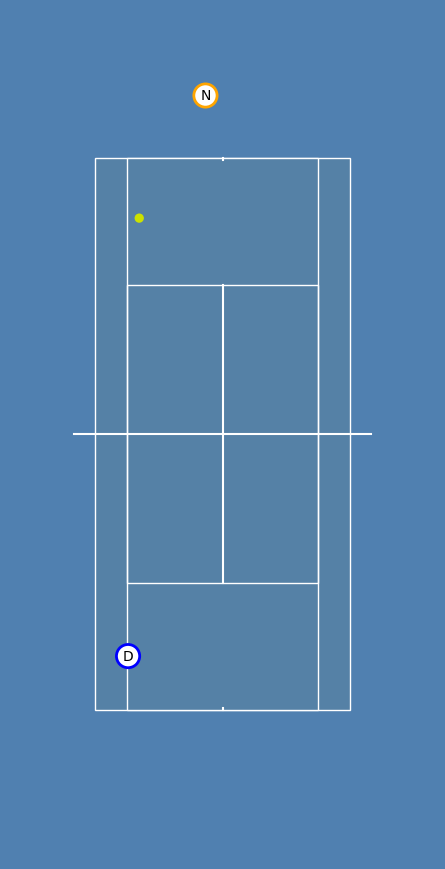

In [196]:
animate_rally(df=shots, rallyid=1, trace=False)